In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from tqdm import tqdm

import os

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import glob

from skimage.color import rgb2lab, rgb2gray, lab2rgb
import torch.nn.functional as F
import cv2
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!rm -rf train

In [ ]:
# Load train dataset
os.mkdir('train/')
!tar --exclude='*/Annotations' --exclude='*.txt' -xzvf "/content/gdrive/MyDrive/ILSVRC2017_DET.tar.gz" -C "train/"


Streaming output truncated to the last 5000 lines.
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00010770.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00018827.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00019127.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00015218.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00012333.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00015239.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00011003.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00019000.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00010924.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00011950.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00015870.JPEG
ILSVRC/Data/DET/train/ILSVRC2013_train_extra1/ILSVRC2013_train_00016922.JPEG
ILSVRC/Data/DET/train/ILS

In [ ]:
from skimage.util.dtype import img_as_float32
class ColorizeDataset(Dataset):
  def __init__(self, root, transform):
    self.paths =[]

    roots = [root + "/*.JPEG", root + "/*/*.JPEG", root + "/*/*/*.JPEG"]
    for r in roots:
      for img in glob.glob(r):
        self.paths.append(img)

    self.transform = transform

  def __len__(self):
    return (len(self.paths))

  def __getitem__(self, i):
    img = Image.open(self.paths[i]).convert("RGB") # there are grayscale images in the dataset

    if self.transform is not None:
      img = self.transform(img)

    img = np.asarray(img)
    label = rgb2lab(img) # Convert the input image from RGB to LAB color space
    label = (label + 128) / 255 # Normalize the LAB values
    label = label[:, :, 1:3] # Get the "ab" channels from the LAB image
    label = torch.from_numpy(label.transpose((2, 0, 1))).float()
    image = rgb2gray(img)
    image = torch.from_numpy(image)
    image = image.unsqueeze(0).float() # Convert the grayscale image to a PyTorch tensor and add a batch dimension

    return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize((224, 224)),
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

In [ ]:
# Define hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

In [ ]:
train_dataset = ColorizeDataset(root='/content/train/ILSVRC/Data/DET/train', transform=train_transform)
val_dataset = ColorizeDataset(root='/content/train/ILSVRC/Data/DET/val', transform=val_transform)

In [ ]:
train_dataset, other_dataset = random_split(train_dataset, [0.4, 0.6], generator=torch.Generator().manual_seed(99))

In [ ]:
val_dataset, other_val_dataset = random_split(train_dataset, [0.2, 0.8], generator=torch.Generator().manual_seed(99))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
test_dataset = ColorizeDataset(root='/content/train/ILSVRC/Data/DET/test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

182627
torch.Size([1, 224, 224])
torch.Size([2, 224, 224])


In [ ]:
print(len(val_dataset))
print(val_dataset[0][0].shape)
print(val_dataset[0][1].shape)

36526
torch.Size([1, 224, 224])
torch.Size([2, 224, 224])


In [ ]:
print(len(test_dataset))
print(test_dataset[0][0].shape)
print(test_dataset[0][1].shape)

60000
torch.Size([1, 224, 224])
torch.Size([2, 224, 224])


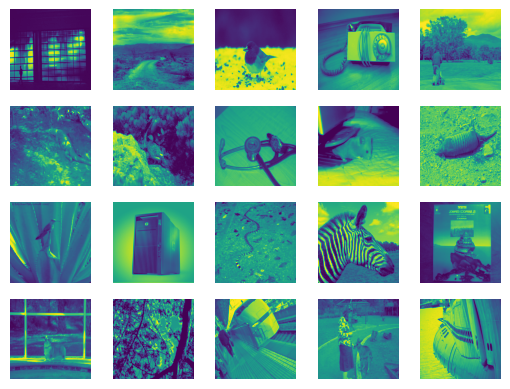

In [ ]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.axis(False)
    plt.imshow(train_dataset[i][0].permute(1,2,0))

In [ ]:
class ColorCNN(nn.Module):
    def __init__(self, input_size=128):
        super(ColorCNN, self).__init__()

        resnet = models.resnet34(pretrained=True, num_classes=1000)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])

        feature_size= 128

        self.decoder = nn.Sequential(
          nn.Conv2d(feature_size, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
      encoded = self.encoder(input)
      decoded = self.decoder(encoded)
      return decoded

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def train(epoch, model, train_loader, criterion, optimizer):
    model.train()
    total = 0
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += images.size(0)
        total_loss += loss.item() * images.size(0)
    loss = total_loss / total
    print(f'Train epoch {epoch}: Loss({loss:6.4f})')
    return loss

In [ ]:
def validate(epoch, model, val_loader, criterion):
  state = model.training
  model.eval()
  total_loss = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
    loss = total_loss / total
    model.training = state
    print(f'Validate epoch {epoch} Loss({loss:6.4f})')
    return loss

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)

          loss = criterion(outputs, labels)
          total_loss += loss.item() * images.size(0)
          total += images.size(0)
    test_loss = total_loss / total
    print("Test loss: {}".format(test_loss))

In [ ]:
# Initialize the model, criterion, and optimizer
#model = ColorCNN()
model = torch.load('/content/gdrive/MyDrive/newmodel4.pt', map_location ='cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train and validate the model for several epochs - run 1
train_loss_history = []
val_loss_history = []
best_val_loss = 1
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    val_loss = validate(epoch, model, val_loader, criterion)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        num_epochs_since_improvement = 0
    else:
        num_epochs_since_improvement += 1
        if num_epochs_since_improvement >= early_stop_patience:
            print(f"No improvement in {early_stop_patience} epochs. Stopping early.")
            break

Train epoch 0: Loss(0.0053)
Validate epoch 0 Loss(0.0038)
Train epoch 1: Loss(0.0038)
Validate epoch 1 Loss(0.0038)
Train epoch 2: Loss(0.0037)
Validate epoch 2 Loss(0.0040)
Train epoch 3: Loss(0.0038)
Validate epoch 3 Loss(0.0037)
Train epoch 4: Loss(0.0037)
Validate epoch 4 Loss(0.0037)
Train epoch 5: Loss(0.0036)
Validate epoch 5 Loss(0.0036)
Train epoch 6: Loss(0.0036)
Validate epoch 6 Loss(0.0036)
Train epoch 7: Loss(0.0035)
Validate epoch 7 Loss(0.0036)
Train epoch 8: Loss(0.0035)
Validate epoch 8 Loss(0.0040)
Train epoch 9: Loss(0.0035)
Validate epoch 9 Loss(0.0036)


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/newmodel1.pt')
torch.save(model, '/content/newmodel1.pt')

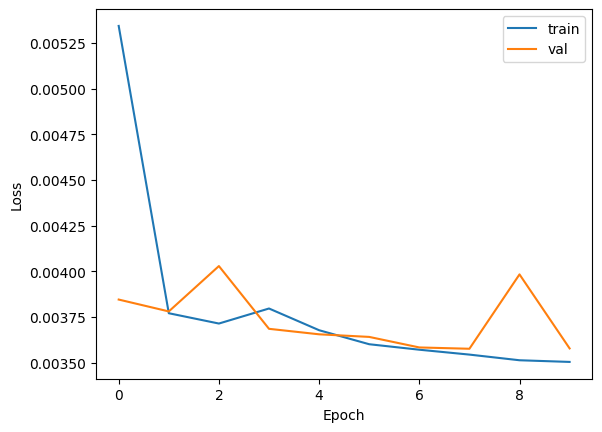

In [ ]:
# Plot the training and validation curves
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Train and validate the model for several epochs - run 2
train_loss_history = []
val_loss_history = []
best_val_loss = 1
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    val_loss = validate(epoch, model, val_loader, criterion)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        num_epochs_since_improvement = 0
    else:
        num_epochs_since_improvement += 1
        if num_epochs_since_improvement >= early_stop_patience:
            print(f"No improvement in {early_stop_patience} epochs. Stopping early.")
            break

Train epoch 0: Loss(0.0031)
Validate epoch 0 Loss(0.0034)
Train epoch 1: Loss(0.0031)
Validate epoch 1 Loss(0.0032)
Train epoch 2: Loss(0.0031)
Validate epoch 2 Loss(0.0030)
Train epoch 3: Loss(0.0030)
Validate epoch 3 Loss(0.0030)
Train epoch 4: Loss(0.0030)
Validate epoch 4 Loss(0.0030)
Train epoch 5: Loss(0.0030)
Validate epoch 5 Loss(0.0030)
Train epoch 6: Loss(0.0030)
Validate epoch 6 Loss(0.0030)
Train epoch 7: Loss(0.0029)
Validate epoch 7 Loss(0.0029)
Train epoch 8: Loss(0.0029)
Validate epoch 8 Loss(0.0029)
Train epoch 9: Loss(0.0029)
Validate epoch 9 Loss(0.0030)


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/newmodel2.pt')

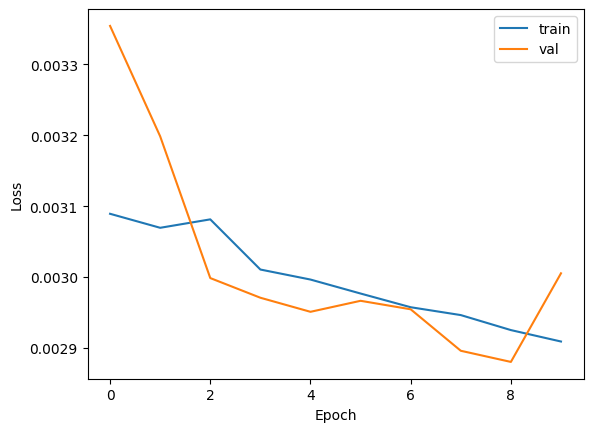

In [ ]:
# Plot the training and validation curves
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Train and validate the model for several epochs - run 3
train_loss_history = []
val_loss_history = []
best_val_loss = 1000
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    val_loss = validate(epoch, model, val_loader, criterion)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        num_epochs_since_improvement = 0
    else:
        num_epochs_since_improvement += 1
        if num_epochs_since_improvement >= early_stop_patience:
            print(f"No improvement in {early_stop_patience} epochs. Stopping early.")
            break

Train epoch 0: Loss(0.0029)
Validate epoch 0 Loss(0.0030)
Train epoch 1: Loss(0.0029)
Validate epoch 1 Loss(0.0029)
Train epoch 2: Loss(0.0029)
Validate epoch 2 Loss(0.0029)
Train epoch 3: Loss(0.0029)
Validate epoch 3 Loss(0.0029)
Train epoch 4: Loss(0.0028)
Validate epoch 4 Loss(0.0028)
Train epoch 5: Loss(0.0028)
Validate epoch 5 Loss(0.0028)
Train epoch 6: Loss(0.0028)
Validate epoch 6 Loss(0.0028)
Train epoch 7: Loss(0.0028)
Validate epoch 7 Loss(0.0028)
Train epoch 8: Loss(0.0028)
Validate epoch 8 Loss(0.0028)
Train epoch 9: Loss(0.0028)
Validate epoch 9 Loss(0.0028)


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/newmodel3.pt')
torch.save(model, '/content/newmodel3.pt')

In [ ]:
# Plot the training and validation curves
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# Train and validate the model for several epochs - run 4
train_loss_history = []
val_loss_history = []
best_val_loss = 1
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    val_loss = validate(epoch, model, val_loader, criterion)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        num_epochs_since_improvement = 0
    else:
        num_epochs_since_improvement += 1
        if num_epochs_since_improvement >= early_stop_patience:
            print(f"No improvement in {early_stop_patience} epochs. Stopping early.")
            break

Train epoch 0: Loss(0.0028)
Validate epoch 0 Loss(0.0028)
Train epoch 1: Loss(0.0028)
Validate epoch 1 Loss(0.0027)
Train epoch 2: Loss(0.0027)
Validate epoch 2 Loss(0.0027)
Train epoch 3: Loss(0.0027)
Validate epoch 3 Loss(0.0027)
Train epoch 4: Loss(0.0027)
Validate epoch 4 Loss(0.0027)
Train epoch 5: Loss(0.0027)
Validate epoch 5 Loss(0.0027)
Train epoch 6: Loss(0.0027)
Validate epoch 6 Loss(0.0027)
Train epoch 7: Loss(0.0027)
Validate epoch 7 Loss(0.0027)
Train epoch 8: Loss(0.0028)
Validate epoch 8 Loss(0.0027)
Train epoch 9: Loss(0.0027)
Validate epoch 9 Loss(0.0026)


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/newmodel4.pt')

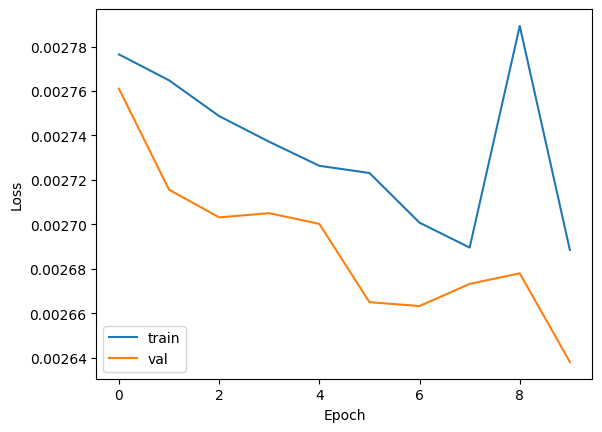

In [ ]:
# Plot the training and validation curves
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Train and validate the model for several epochs - run 5
train_loss_history = []
val_loss_history = []
best_val_loss = 1000
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    val_loss = validate(epoch, model, val_loader, criterion)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        num_epochs_since_improvement = 0
    else:
        num_epochs_since_improvement += 1
        if num_epochs_since_improvement >= early_stop_patience:
            print(f"No improvement in {early_stop_patience} epochs. Stopping early.")
            break

Train epoch 0: Loss(0.0029)
Validate epoch 0 Loss(0.0031)
Train epoch 1: Loss(0.0029)
Validate epoch 1 Loss(0.0031)
Train epoch 2: Loss(0.0029)
Validate epoch 2 Loss(0.0030)
Train epoch 3: Loss(0.0029)
Validate epoch 3 Loss(0.0031)
Train epoch 4: Loss(0.0029)
Validate epoch 4 Loss(0.0029)
Train epoch 5: Loss(0.0029)
Validate epoch 5 Loss(0.0029)
Train epoch 6: Loss(0.0028)
Validate epoch 6 Loss(0.0029)


In [ ]:
torch.save(model, '/content/gdrive/MyDrive/newmodel5.pt')

In [ ]:
# Plot the training and validation curves
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Test the model on the test set
test(model, test_loader, criterion)

Test loss: 0.004086282588168979


In [ ]:
def to_rgb(grayscale_input, ab_input):
  plt.clf()
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  # don't use grayscale use L
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  plt.imsave(arr=color_image, fname="/content/output.jpg")


In [ ]:
input_gray = cv2.imread('/content/train/ILSVRC/Data/DET/train/ILSVRC2013_train_extra10/ILSVRC2013_train_00100000.JPEG')
plt.imsave(arr=input_gray, fname="/content/original.jpg")
input_gray = cv2.resize(input_gray, (256,256))
input_gray = rgb2gray(input_gray)
plt.imsave(arr=input_gray, fname="/content/input.jpg")
input_gray = torch.from_numpy(input_gray).unsqueeze(0).float()
input_gray = torch.unsqueeze(input_gray, dim=0).cuda()
model.eval()
output_ab = model(input_gray)
to_rgb(input_gray[0].cpu(), output_ab[0].detach().cpu())


<Figure size 640x480 with 0 Axes>

mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]